# SPEI计算

使用`climate-indices`库直接进行计算。

<https://climate-indices.readthedocs.io/en/latest/index.html#spei-monthly>

In [39]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from climate_indices import compute, indices, utils

文档有点少，先进行测试计算

In [40]:
test_pet_frame = xr.open_dataset('../../outputs/pet-resampled/2000_07.tif').squeeze("band",drop=True)
test_precip_frame = xr.open_dataset('../../outputs/precip-cutted/_2000_2002_7.tif').squeeze("band",drop=True)

In [41]:
test_pet_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

In [42]:
test_precip_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

这个库文档太少，这里使用手动计算测试

## SPEI计算方法

### 收集相关数据

这里需要逐月降水$P_i$和潜在蒸散发$PET_i$的数据。

### 计算差值序列

$$ D_i=P_i-PET_i $$

### 将序列推广到时间尺度

$$ D_n^k=\sum_{i=0}^{k-1}(P_{n-i}-PET_{n-i}),\quad n\ge k $$

### 对${D_n^K}$进行正态化

通常认为该差值$D$服从三参数Log-logisitic分布，又称Fisk分布。

$$ f(x;\kappa,\mu,\lambda)=\frac{\lambda\kappa[\lambda(x-\mu)]^{\kappa-1}}{[1+\lambda^\kappa(x-\mu)^\kappa]^2} $$

其中，$\kappa, \lambda, \mu$分别为形状、尺度和起始参数。对其进行参数估计以得到相关参数。将其带入分布函数

$$ F(x;\kappa,\mu,\lambda)=(1+[\lambda(x-\mu)^\kappa])^{-1} $$

得到序列的概率分布。概率分布函数带入对应$D_i$的值就得到标准化处理之前的SPEI值。

之后进行正态标准化处理，

$$ P=1-F(X) $$

带入标准化计算式，即得SPEI。


先进行数据可视化来验证计算结果

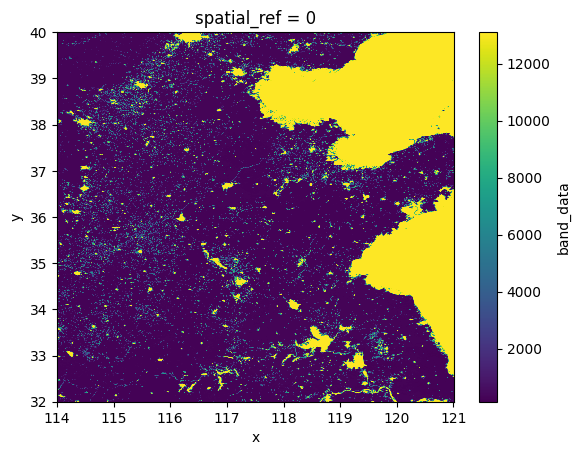

In [43]:
test_pet_frame.band_data.plot()

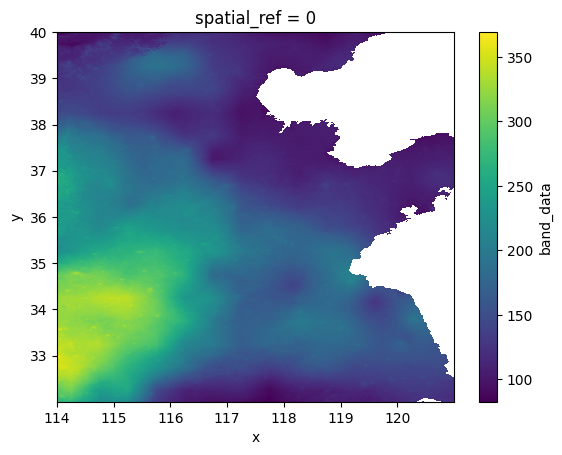

In [44]:
(test_precip_frame.band_data*0.1).plot()


In [45]:
a=(test_precip_frame.band_data*0.1).to_numpy()

In [46]:
b=test_pet_frame.band_data.to_numpy()

In [47]:
test_precip_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 886.0 885.0 884.0 ... 1.23e+03 1.21e+03